In [29]:
import sys

assert sys.version_info >= (3, 7)
import sklearn

assert sklearn.__version__ >= "1.0.1"
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
from pathlib import Path

IMAGES_PATH = Path() / "images" / "regression"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Before we look at the tasks, we'll clean the data.

In [30]:
import pandas as pd

# Load the Bike Shop dataset from Git
url = 'https://raw.githubusercontent.com/VAWi-DataScience/Data-Science-and-Machine-Learning/main/Assignment/WiSe22_23/02_Bike%20rental.csv'
bikeRentalDF = pd.read_csv(url)
bikeRentalDF.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [31]:
# Drop the 'instant' column as it is just a record index and not useful for modeling
bikeRentalDF.drop('instant', axis=1, inplace=True)

In [32]:
bikeRentalDF.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [33]:
print(bikeRentalDF.dtypes)

dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


In [34]:
import datetime as dt
# Convert 'dteday' column to datetime format
bikeRentalDF['dteday'] = pd.to_datetime(bikeRentalDF['dteday'])
# Because it is easier to work with ordinal values in we convert'dteday'
bikeRentalDF['dteday'] = bikeRentalDF['dteday'].map(dt.datetime.toordinal) 

In [35]:
bikeRentalDF.dtypes

dteday          int64
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [36]:
bikeRentalDF.isna().sum()

dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

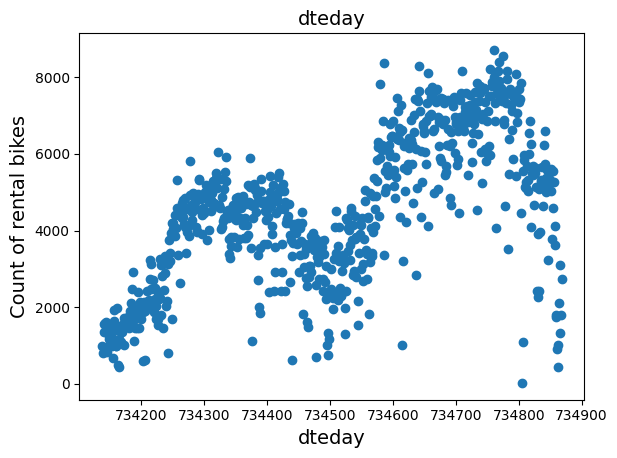

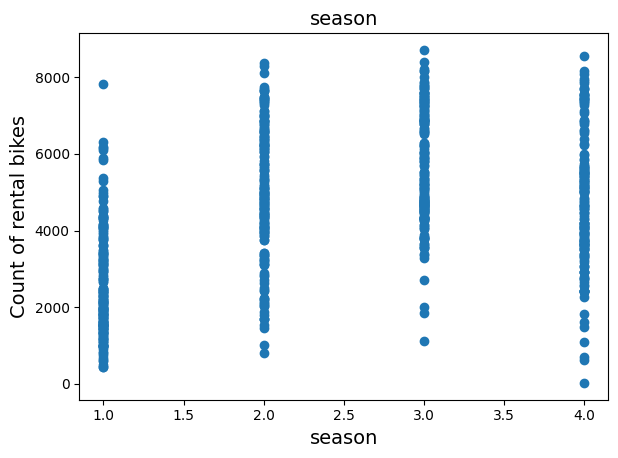

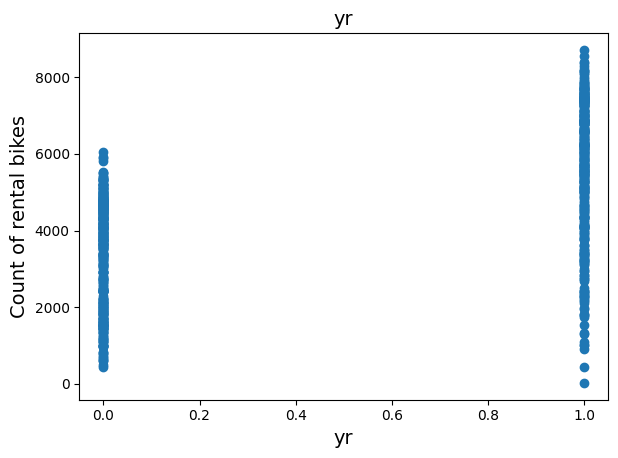

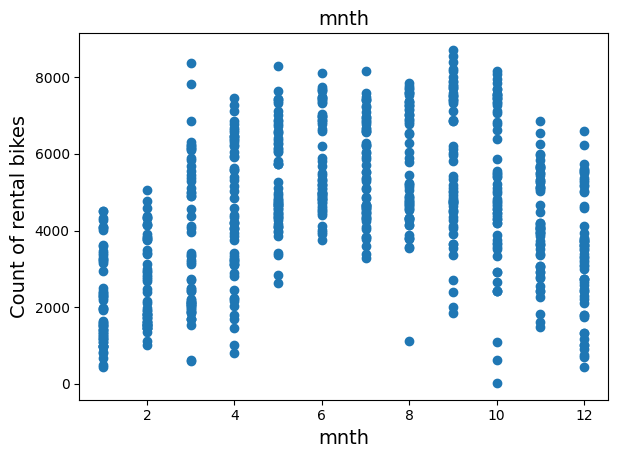

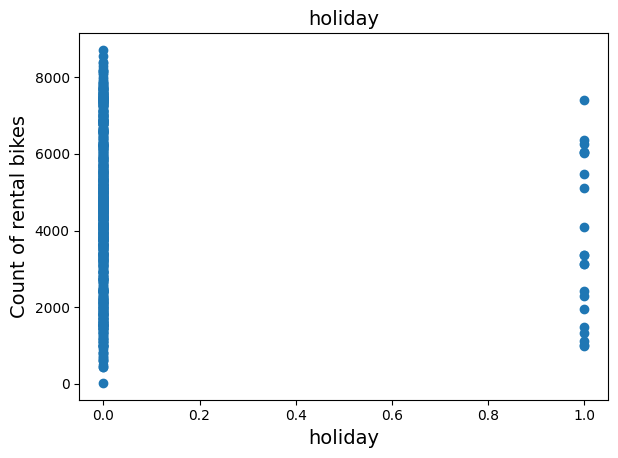

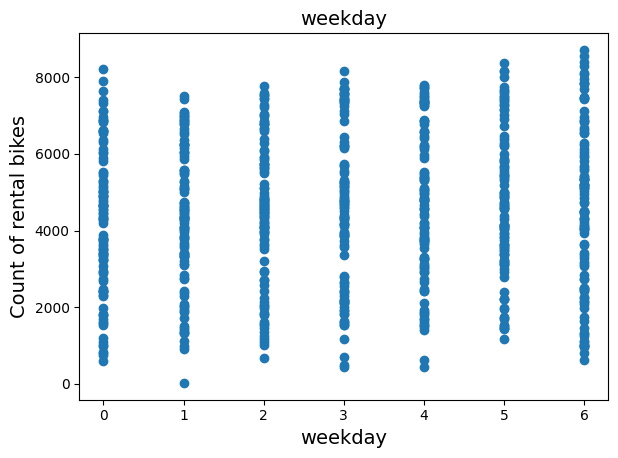

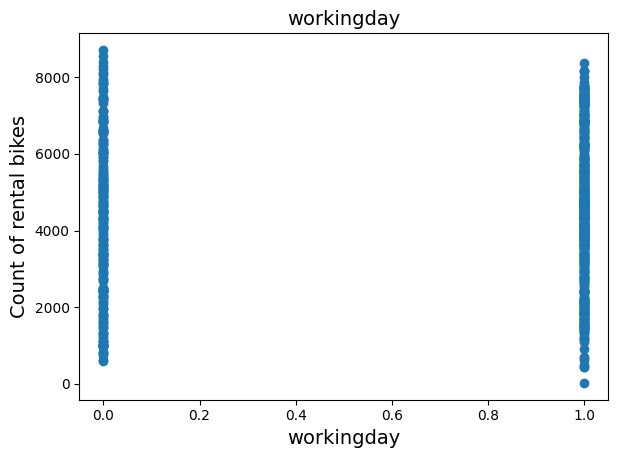

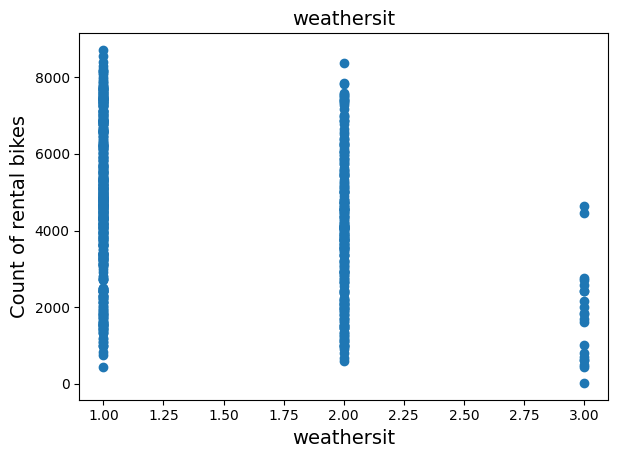

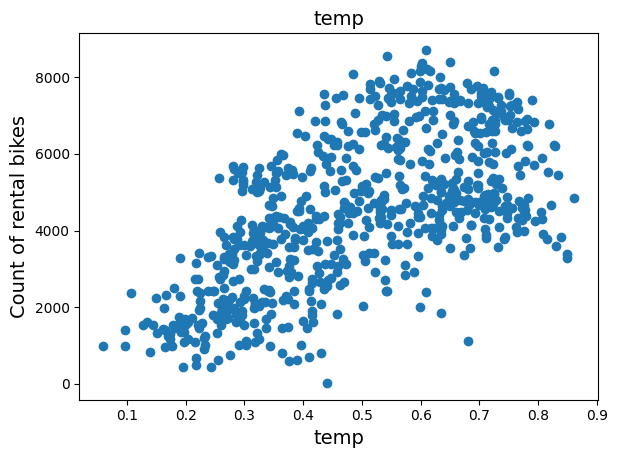

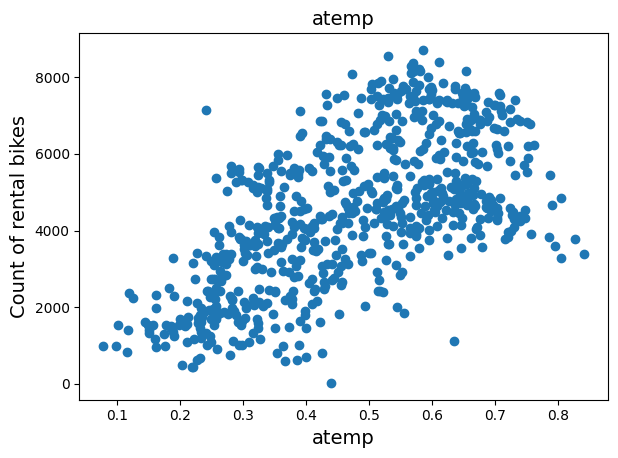

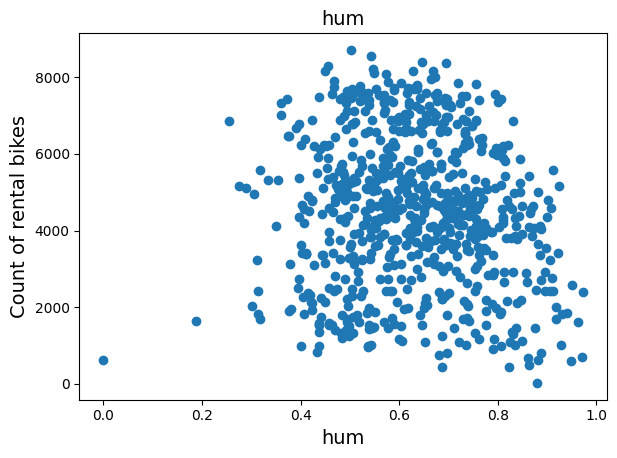

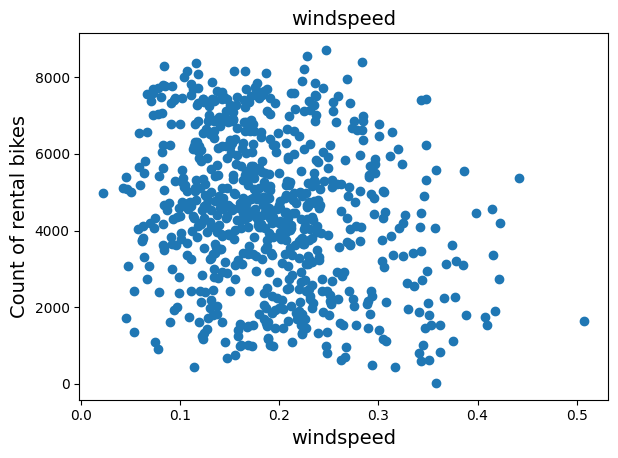

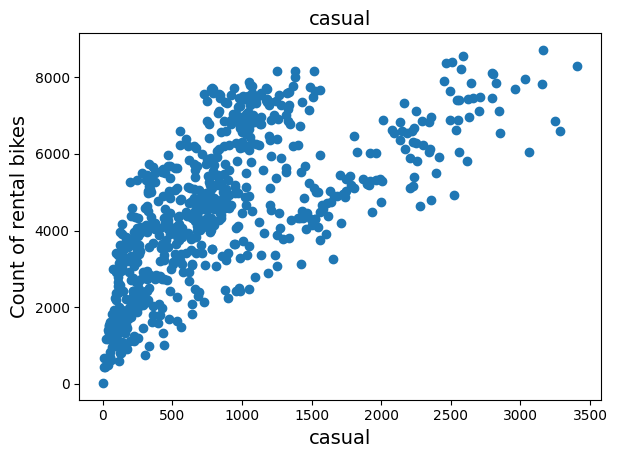

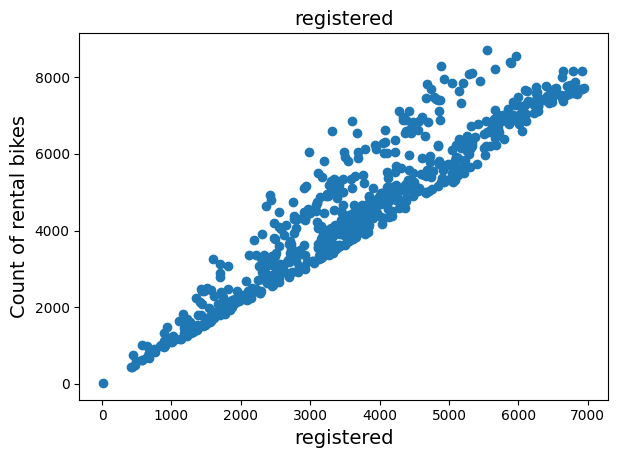

In [37]:
for label in bikeRentalDF.columns[0:-1]:
    plt.scatter(bikeRentalDF[label], bikeRentalDF["cnt"])
    plt.title(label)
    plt.ylabel("Count of rental bikes")
    plt.xlabel(label)
    save_fig('assignment02_fig1' + label)
    plt.show()

Because the feature dteday has significantly larger values than all the others, we normalise all features with the StandardScaler.

In [38]:
from sklearn.preprocessing import StandardScaler
feature_set = ['dteday', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
scaler = StandardScaler()
bikeRentalDF[feature_set] = scaler.fit_transform(bikeRentalDF[feature_set])

In [39]:
bikeRentalDF.describe()


,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,7.310000e+02,7.310000e+02,7.310000e+02,7.310000e+02,7.310000e+02,7.310000e+02,7.310000e+02,7.310000e+02,7.310000e+02,731.000000,731.000000,731.000000
mean,0.000000,2.496580,0.000000,3.888059e-17,4.252564e-17,2.885669e-17,-1.075291e-16,-9.720147e-18,-4.179663e-16,2.916044e-17,-9.914550e-16,-2.138432e-16,848.176471,3656.172367,4504.348837
std,1.000685,1.110807,1.000685,1.000685e+00,1.000685e+00,1.000685e+00,1.000685e+00,1.000685e+00,1.000685e+00,1.000685e+00,1.000685e+00,1.000685e+00,686.622488,1560.256377,1937.211452
min,-1.729683,1.000000,-1.001369,-1.600161e+00,-1.719810e-01,-1.496077e+00,-1.471225e+00,-7.260482e-01,-2.384871e+00,-2.427296e+00,-4.411486e+00,-2.170506e+00,2.000000,20.000000,22.000000
25%,-0.864841,2.000000,-1.001369,-7.304823e-01,-1.719810e-01,-9.969297e-01,-1.471225e+00,-7.260482e-01,-8.653855e-01,-8.382669e-01,-7.580469e-01,-7.171066e-01,315.500000,2497.000000,3152.000000
50%,0.000000,3.000000,0.998633,1.391961e-01,-1.719810e-01,1.365657e-03,6.797058e-01,-7.260482e-01,1.611698e-02,7.601496e-02,-8.621154e-03,-1.228127e-01,713.000000,3662.000000,4548.000000
75%,0.864841,3.000000,0.998633,1.008875e+00,-1.719810e-01,9.996610e-01,6.797058e-01,1.110427e+00,8.748452e-01,8.243677e-01,7.188453e-01,5.517254e-01,1096.000000,4776.500000,5956.000000
max,1.729683,4.000000,0.998633,1.588660e+00,5.814596e+00,1.498809e+00,6.797058e-01,2.946901e+00,2.002355e+00,2.250800e+00,2.421148e+00,4.092936e+00,3410.000000,6946.000000,8714.000000



# 1. Train and evaluate two different multiple regression models using different optimization algorithms. Describe your approach, interpret the performance, and justify which machine learning model you would choose.

In [40]:
# Import train_test_split function  
from sklearn.model_selection import train_test_split

# First we split the data in training and testsets

X = bikeRentalDF[feature_set] # input features
y = bikeRentalDF.cnt # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Training Multiple Linear Regression Models

### 1. Linear Regression with Normal Equation

In [41]:
# Import linear regression model
from sklearn.linear_model import LinearRegression
 
# Create linear regression model
lin_reg = LinearRegression()
 
# Fit the linear regression model
lin_reg.fit(X_train, y_train)

LinearRegression()

In [42]:
predictions_train = lin_reg.predict(X_train)
# Import the required libraries
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
 
# Evaluate mean absolute error
print('Mean Absolute Error(MAE):', mean_absolute_error(y_train,predictions_train))  
 
# Evaluate mean squared error
print("Mean Squared Error(MSE):", mean_squared_error(y_train, predictions_train))  
 
# Evaluate root mean squared error
print("Root Mean Squared Error(RMSE):", np.sqrt(mean_squared_error(y_train, predictions_train)))
 
# Evaluate R2-square
print("R2-Square:",r2_score(y_train, predictions_train))

Mean Absolute Error(MAE): 687.7161225485874
Mean Squared Error(MSE): 848536.5227247014
Root Mean Squared Error(RMSE): 921.1604218184265
R2-Square: 0.7685200196075215


Visualize regression line

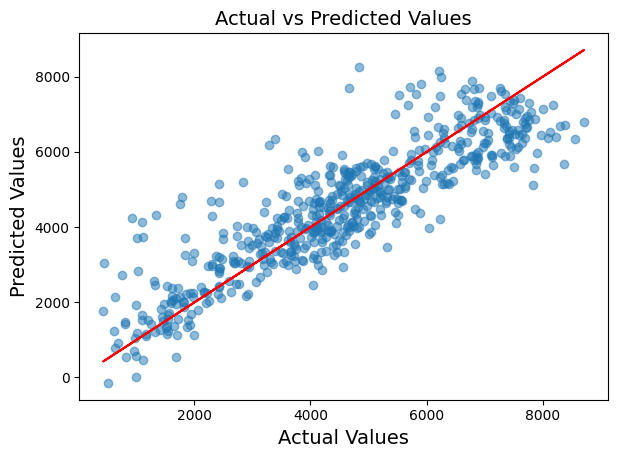

In [43]:
import matplotlib.pyplot as plt

# Plot the actual values against the predicted values
plt.scatter(y_train, predictions_train, alpha=0.5)
plt.plot(y_train, y_train, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
save_fig('assignment02_fig2')
plt.show()


In [44]:
#Predict the given test set
predictions_test = lin_reg.predict(X_test)
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Evaluate mean absolute error
print('Mean Absolute Error(MAE):', mean_absolute_error(y_test,predictions_test))
# Evaluate mean squared error
print("Mean Squared Error(MSE):", mean_squared_error(y_test, predictions_test))
# Evaluate root mean squared error
print("Root Mean Squared Error(RMSE):", np.sqrt(mean_squared_error(y_test, predictions_test)))
# Evaluate R2-square
print("R2-Square:",r2_score(y_test, predictions_test))

Mean Absolute Error(MAE): 678.4724547937502
Mean Squared Error(MSE): 788245.8745821817
Root Mean Squared Error(RMSE): 887.832120720005
R2-Square: 0.8034241860848641


### 2. Linear regression with Gradient Descent

In [45]:
# Import linear regression model
from sklearn.linear_model import SGDRegressor
# Create linear regression model
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
n_iter_no_change=100, random_state=42)
# Fit the linear regression model
sgd_reg.fit(X_train, y_train.ravel())# y.ravel() because fit() expects 1D targets

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [46]:
predictions_train_sgd_reg = sgd_reg.predict(X_train)
# Import the required libraries
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Evaluate mean absolute error
print('Mean Absolute Error(MAE):', mean_absolute_error(y_train,predictions_train_sgd_reg))
# Evaluate mean squared error
print("Mean Squared Error(MSE):", mean_squared_error(y_train, predictions_train_sgd_reg))
# Evaluate root mean squared error
print("Root Mean Squared Error(RMSE):", np.sqrt(mean_squared_error(y_train,
predictions_train_sgd_reg)))
# Evaluate R2-square
print("R2-Square:",r2_score(y_train, predictions_train_sgd_reg))

Mean Absolute Error(MAE): 690.8571619255514
Mean Squared Error(MSE): 852874.6129710658
Root Mean Squared Error(RMSE): 923.51210764725
R2-Square: 0.767336592591387


In [47]:
predictions_test_sgd_reg = sgd_reg.predict(X_test)
# Import the required libraries
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Evaluate mean absolute error
print('Mean Absolute Error(MAE):', mean_absolute_error(y_test,predictions_test_sgd_reg))
# Evaluate mean squared error
print("Mean Squared Error(MSE):", mean_squared_error(y_test, predictions_test_sgd_reg))
# Evaluate root mean squared error
print("Root Mean Squared Error(RMSE):", np.sqrt(mean_squared_error(y_test,
predictions_test_sgd_reg)))
# Evaluate R2-square
print("R2-Square:",r2_score(y_test, predictions_test_sgd_reg))

Mean Absolute Error(MAE): 683.0237877372027
Mean Squared Error(MSE): 806077.5792053462
Root Mean Squared Error(RMSE): 897.8182328318724
R2-Square: 0.7989772464143572


Looking at the results, we can see that both models have similar performance in terms of the MAE, MSE, and RMSE values. However, the model with the normal equation has a slightly higher R2-square value than the model with gradient descent for both training and test data. The R2-square measures the proportion of the variance in the target variable that can be explained by the model. Therefore, a higher R2-square value indicates a better fit of the model to the data.

# 2. Train and evaluate a polynomial regression model. Test at least two different models. Describe your approach, interpret the performance, and compare the results to the chosen machine learning model from task 1. Which machine learning model would you choose? 

In [48]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X) # adding the square

In [49]:
# Partition data into training and testing set
from sklearn.model_selection import train_test_split
# Partition data into training and testing set
X_train,X_test, y_train, y_test = train_test_split(X_poly, bikeRentalDF.cnt, test_size=0.2,
random_state=42)

In [50]:
from sklearn.linear_model import LinearRegression
lin_reg_poly_2 = LinearRegression()
lin_reg_poly_2.fit(X_train, y_train)

LinearRegression()

In [51]:
predictions_train_lin_reg_poly = lin_reg_poly_2.predict(X_train)
# Import the required libraries
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Evaluate mean absolute error
print('Mean Absolute Error(MAE):', mean_absolute_error(y_train,predictions_train_lin_reg_poly))
# Evaluate mean squared error
print("Mean Squared Error(MSE):", mean_squared_error(y_train, predictions_train_lin_reg_poly))
# Evaluate root mean squared error
print("Root Mean Squared Error(RMSE):", np.sqrt(mean_squared_error(y_train,
predictions_train_lin_reg_poly)))
# Evaluate R2-square
print("R2-Square:",r2_score(y_train, predictions_train_lin_reg_poly))

Mean Absolute Error(MAE): 446.9871742562072
Mean Squared Error(MSE): 352475.0287684676
Root Mean Squared Error(RMSE): 593.6960744088406
R2-Square: 0.9038451374064962


In [52]:
predictions_test_lin_reg_poly = lin_reg_poly_2.predict(X_test)
# Import the required libraries
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Evaluate mean absolute error
print('Mean Absolute Error(MAE):', mean_absolute_error(y_test,predictions_test_lin_reg_poly))
# Evaluate mean squared error
print("Mean Squared Error(MSE):", mean_squared_error(y_test, predictions_test_lin_reg_poly))
# Evaluate root mean squared error
print("Root Mean Squared Error(RMSE):", np.sqrt(mean_squared_error(y_test,
predictions_test_lin_reg_poly)))
# Evaluate R2-square
print("R2-Square:",r2_score(y_test, predictions_test_lin_reg_poly))


Mean Absolute Error(MAE): 595.0375744047619
Mean Squared Error(MSE): 635913.7648731153
Root Mean Squared Error(RMSE): 797.4420134863195
R2-Square: 0.8414133585208659


In [53]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)

# Partition data into training and testing set
from sklearn.model_selection import train_test_split
# Partition data into training and testing set
X_train,X_test, y_train, y_test = train_test_split(X_poly, bikeRentalDF.cnt, test_size=0.2,
random_state=42)

from sklearn.linear_model import LinearRegression
lin_reg_poly_3 = LinearRegression()
lin_reg_poly_3.fit(X_train, y_train)

predictions_train_lin_reg_poly = lin_reg_poly_3.predict(X_train)
# Import the required libraries
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Evaluate mean absolute error
print('Mean Absolute Error(MAE):', mean_absolute_error(y_train,predictions_train_lin_reg_poly))
# Evaluate mean squared error
print("Mean Squared Error(MSE):", mean_squared_error(y_train, predictions_train_lin_reg_poly))
# Evaluate root mean squared error
print("Root Mean Squared Error(RMSE):", np.sqrt(mean_squared_error(y_train,
predictions_train_lin_reg_poly)))
# Evaluate R2-square
print("R2-Square:",r2_score(y_train, predictions_train_lin_reg_poly))




Mean Absolute Error(MAE): 259.6011289611255
Mean Squared Error(MSE): 127041.99128649588
Root Mean Squared Error(RMSE): 356.4295039506352
R2-Square: 0.9653430620079974


In [54]:
predictions_test_lin_reg_poly = lin_reg_poly_3.predict(X_test)
# Import the required libraries
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Evaluate mean absolute error
print('Mean Absolute Error(MAE):', mean_absolute_error(y_test,predictions_test_lin_reg_poly))
# Evaluate mean squared error
print("Mean Squared Error(MSE):", mean_squared_error(y_test, predictions_test_lin_reg_poly))
# Evaluate root mean squared error
print("Root Mean Squared Error(RMSE):", np.sqrt(mean_squared_error(y_test,
predictions_test_lin_reg_poly)))
# Evaluate R2-square
print("R2-Square:",r2_score(y_test, predictions_test_lin_reg_poly))

Mean Absolute Error(MAE): 123243197649.73026
Mean Squared Error(MSE): 4.1892575465744524e+23
Root Mean Squared Error(RMSE): 647244740926.8346
R2-Square: -1.0447332976585602e+17


Based on the results, the quadratic polynomial regression model has a much better performance than the polynomial regression model with degree 3. The quadratic polynomial regression model has a lower MAE, MSE, and RMSE value for both training and test data. The R2-square value is also higher for the quadratic polynomial regression model. Therefore, we can conclude that the quadratic polynomial regression model is a better fit for the data than the polynomial regression model with degree 3.

# 3. Select the machine learning model that you have chosen in task 2. Now try optimizing your results by using hyperparameter tuning (lecture 04). Use cross-validation (lecture 04) when evaluating your results. Please explain your results and interpret them.

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# create a pipeline with polynomial features and ridge regression
pipe = make_pipeline(
    PolynomialFeatures(),
    Ridge()
)

# define the hyperparameter grid to search over
param_grid = {
    'polynomialfeatures__degree': [2, 3, 4],
    'ridge__alpha': [0.01, 0.1, 1, 10, 100]
}

# perform grid search with 5-fold cross-validation
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# print the best hyperparameters and the corresponding validation score
print("Best hyperparameters:", grid.best_params_)
print("Validation score:", -grid.best_score_)


In [ ]:
# TODO Hyperparameter tuning using GridSearchCV